In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

from module import config_lib, utils_lib

In [20]:
cfg = config_lib.CFG()
utils_lib.set_seed(cfg.seed)

In [21]:
train_label = pd.read_csv(cfg.train_csv)
submission = pd.read_csv(cfg.submission_csv)
taxonomy = pd.read_csv(cfg.taxonomy_csv)

In [22]:
train_label.head()

# secoundary labels
train_label[train_label["secondary_labels"] != "['']"]

# 鳴き声タイプ
train_label[train_label["type"] != "['']"].head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
9,126247,"['65448', '22976', '476538']",['advertisement call'],126247/XC941297.ogg,XC,3.5,https://xeno-canto.org/941297,9.0465,-79.3024,Leptodactylus insularum,Spotted Foam-nest Frog,Chris Harrison,cc-by-nc-sa 4.0
20,134933,[''],['advertisement call'],134933/XC941298.ogg,XC,4.0,https://xeno-canto.org/941298,8.6260,-80.1392,Espadarana prosoblepon,Emerald Glass Frog,Chris Harrison,cc-by-nc-sa 4.0
130,22333,[''],['advertisement call'],22333/XC890507.ogg,XC,5.0,https://xeno-canto.org/890507,12.1205,-68.9658,Eleutherodactylus johnstonei,Lesser Antillean whistling frog,Chris Harrison,cc-by-nc-sa 4.0
131,22333,[''],['territorial call'],22333/XC894982.ogg,XC,4.0,https://xeno-canto.org/894982,12.1187,-68.2912,Eleutherodactylus johnstonei,Lesser Antillean whistling frog,Baudewijn Odé,cc-by-nc-sa 4.0
177,22973,[''],['flight call'],22973/XC167037.ogg,XC,4.0,https://xeno-canto.org/167037,3.8284,-67.9020,Leptodactylus fuscus,Whistling Grass Frog,Ottavio Janni,cc-by-nc-sa 3.0


In [23]:
train_label[train_label["rating"] != 0.0]

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
9,126247,"['65448', '22976', '476538']",['advertisement call'],126247/XC941297.ogg,XC,3.5,https://xeno-canto.org/941297,9.0465,-79.3024,Leptodactylus insularum,Spotted Foam-nest Frog,Chris Harrison,cc-by-nc-sa 4.0
20,134933,[''],['advertisement call'],134933/XC941298.ogg,XC,4.0,https://xeno-canto.org/941298,8.6260,-80.1392,Espadarana prosoblepon,Emerald Glass Frog,Chris Harrison,cc-by-nc-sa 4.0
54,21211,[''],[''],21211/XC882646.ogg,XC,4.0,https://xeno-canto.org/882646,NaN,NaN,Allobates femoralis,Spotted-thighed Poison Frog,M.S. Hoogmoed,cc-by 4.0
55,21211,[''],[''],21211/XC882647.ogg,XC,4.0,https://xeno-canto.org/882647,NaN,NaN,Allobates femoralis,Spotted-thighed Poison Frog,M.S. Hoogmoed,cc-by 4.0
56,21211,[''],[''],21211/XC882648.ogg,XC,4.0,https://xeno-canto.org/882648,NaN,NaN,Allobates femoralis,Spotted-thighed Poison Frog,M.S. Hoogmoed,cc-by 4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28534,ywcpar,[''],['flight call'],ywcpar/XC939157.ogg,XC,2.0,https://xeno-canto.org/939157,3.6867,-61.0326,Amazona ochrocephala,Yellow-crowned Parrot,JAYRSON ARAUJO DE OLIVEIRA,cc-by-nc-sa 4.0
28535,ywcpar,[''],['call'],ywcpar/XC939934.ogg,XC,5.0,https://xeno-canto.org/939934,1.7914,-61.1375,Amazona ochrocephala,Yellow-crowned Parrot,JAYRSON ARAUJO DE OLIVEIRA,cc-by-nc-sa 4.0
28536,ywcpar,[''],[''],ywcpar/XC945993.ogg,XC,3.0,https://xeno-canto.org/945993,6.2710,-75.5640,Amazona ochrocephala,Yellow-crowned Parrot,Carlos Delgado JUMABITA,cc-by-nc-sa 4.0
28537,ywcpar,[''],['call'],ywcpar/XC946300.ogg,XC,4.0,https://xeno-canto.org/946300,3.5026,-76.3552,Amazona ochrocephala,Yellow-crowned Parrot,Cristian Rodas,cc-by-nc-sa 4.0


In [24]:
submission.head()

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,soundscape_8358733_5,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,...,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
1,soundscape_8358733_10,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,...,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
2,soundscape_8358733_15,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,...,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854


In [25]:
# ラベルと生物名の対応
taxonomy.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


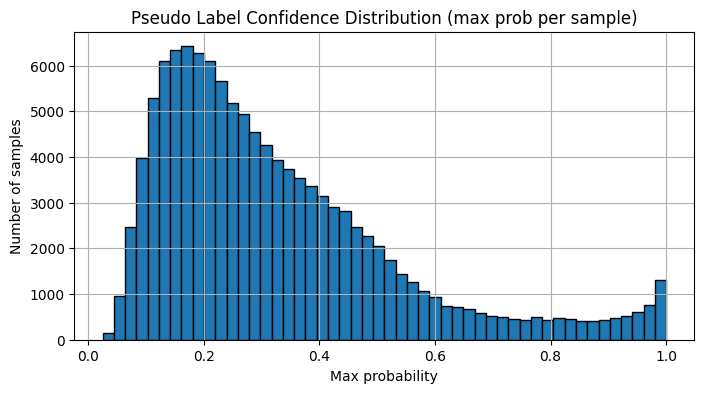

count    116712.000000
mean          0.326734
std           0.208368
min           0.025005
10%           0.118399
25%           0.173247
50%           0.272566
75%           0.422210
90%           0.603672
max           0.999955
dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

pseudo_label_csv = "../data/result/pseudo_labels_baseline_7sec.csv"
# 読み込み
pseudo_df = pd.read_csv(pseudo_label_csv)

# 信頼度（最大確率）を取得
pseudo_confidence = pseudo_df.drop(columns=["row_id"]).max(axis=1)

# 可視化
plt.figure(figsize=(8, 4))
pseudo_confidence.hist(bins=50, edgecolor='black')
plt.title("Pseudo Label Confidence Distribution (max prob per sample)")
plt.xlabel("Max probability")
plt.ylabel("Number of samples")
plt.grid(True)
plt.show()

# 統計情報も確認
print(pseudo_confidence.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

In [27]:
import os
import pandas as pd

model_dir_name = "baseline_fold0_pseudo_prob0.1"
model_dir = os.path.join(cfg.models_dir, model_dir_name)

# スコア格納辞書（foldごとの記録）
score_lists = {
    'val_auc': [],
    'train_auc': [],
    'val_map': [],
    'train_map': [],
    'val_loss': [],
    'train_loss': [],
    'epoch': [],
}

# 各foldのベストスコア収集
for fold in range(5):
    log_path = os.path.join(model_dir, f"log_fold{fold}.csv")
    if not os.path.exists(log_path):
        print(f"Missing log for fold {fold}: {log_path}")
        continue

    df = pd.read_csv(log_path)
    best_row = df.loc[df['val_auc'].idxmax()]

    print(f"Fold {fold} best epoch: {int(best_row['epoch'])}, val_auc: {best_row['val_auc']:.3f}, train_auc: {best_row['train_auc']:.3f}")

    for key in score_lists:
        score_lists[key].append(best_row[key])

# 平均スコアを整形（.3fで表示、epochだけ.2f）
score_means = {}
for key, values in score_lists.items():
    avg = sum(values) / len(values)
    display_key = f"Avg {key.replace('_', ' ').title()}"
    if "epoch" in key:
        score_means[display_key] = f"{avg:.2f}"
    else:
        score_means[display_key] = f"{avg:.3f}"

# config.csv 読み込み
config_path = os.path.join(model_dir, "config.csv")
config_df = pd.read_csv(config_path)

important_keys = [
    'model_name','batch_size', 'epochs',
    'optimizer', 'lr', 'weight_decay', 'scheduler', 'min_lr', "tta",
]

# config情報の統合
config_dict = {"Note": "", "LB AUC": "", **score_means }
for key in important_keys:
    value = config_df.loc[config_df['key'] == key, 'value'].values
    config_dict[key] = value[0] if len(value) > 0 else ""

# Markdown出力
all_keys = list(config_dict.keys())
print("\n```markdown")
print("| " + " | ".join(all_keys) + " |")
print("|" + "|".join(["-" * (len(k)+2) for k in all_keys]) + "|")
print("| " + " | ".join(str(config_dict[k]) for k in all_keys) + " |")
print("```")

Fold 0 best epoch: 6, val_auc: 0.942, train_auc: 0.965
Missing log for fold 1: ../models/baseline_fold0_pseudo_prob0.1/log_fold1.csv
Missing log for fold 2: ../models/baseline_fold0_pseudo_prob0.1/log_fold2.csv
Missing log for fold 3: ../models/baseline_fold0_pseudo_prob0.1/log_fold3.csv
Missing log for fold 4: ../models/baseline_fold0_pseudo_prob0.1/log_fold4.csv

```markdown
| Note | LB AUC | Avg Val Auc | Avg Train Auc | Avg Val Map | Avg Train Map | Avg Val Loss | Avg Train Loss | Avg Epoch | model_name | batch_size | epochs | optimizer | lr | weight_decay | scheduler | min_lr | tta |
|------|--------|-------------|---------------|-------------|---------------|--------------|----------------|-----------|------------|------------|--------|-----------|----|--------------|-----------|--------|-----|
|  |  | 0.942 | 0.965 | 0.468 | 0.482 | 0.016 | 0.015 | 6.00 | efficientnet_b0 | 32 | 10 | AdamW | 0.0005 | 1e-05 | CosineAnnealingLR | 1e-06 |  |
```


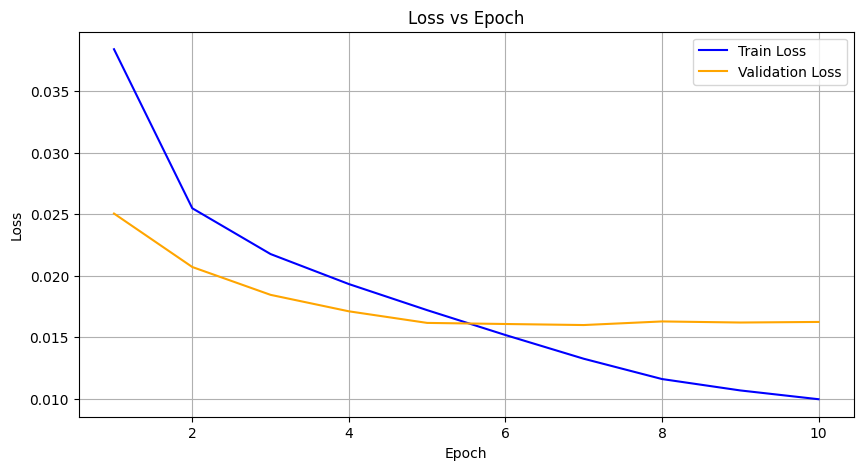

In [28]:
model_dir_name = "baseline_fold0_pseudo_prob0.1"
model_dir = os.path.join(cfg.models_dir, model_dir_name)
log_path = os.path.join(model_dir, f"log_fold{0}.csv")

# lossをプロット
df = pd.read_csv(log_path)
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

In [10]:
import torch
import numpy as np

val_auc_list = []
train_auc_list = []
best_epoch_list = []

for i in range(5):
    path = f"../models/models_0401/model_fold{i}.pth"
    checkpoint = torch.load(path, map_location='cpu')
    
    best_epoch = checkpoint.get('epoch') + 1  # epochは0始まりが多いので+1するのが自然
    val_auc = checkpoint.get('val_auc')
    train_auc = checkpoint.get('train_auc')

    print(f"Fold {i}")
    print(f"Best Epoch: {best_epoch}")
    print(f"Val AUC: {val_auc:.3f}")
    print(f"Train AUC: {train_auc:.3f}")
    print()

    val_auc_list.append(val_auc)
    train_auc_list.append(train_auc)
    best_epoch_list.append(best_epoch)

# 平均の計算と表示
mean_val_auc = np.mean(val_auc_list)
mean_train_auc = np.mean(train_auc_list)
mean_best_epoch = np.mean(best_epoch_list)

print("========== Averages ==========")
print(f"Average Best Epoch : {mean_best_epoch:.2f}")
print(f"Average Val AUC    : {mean_val_auc:.3f}")
print(f"Average Train AUC  : {mean_train_auc:.3f}")


Fold 0
Best Epoch: 35
Val AUC: 0.913
Train AUC: 0.976

Fold 1
Best Epoch: 27
Val AUC: 0.924
Train AUC: 0.963

Fold 2
Best Epoch: 31
Val AUC: 0.923
Train AUC: 0.983

Fold 3
Best Epoch: 30
Val AUC: 0.929
Train AUC: 0.983

Fold 4
Best Epoch: 27
Val AUC: 0.926
Train AUC: 0.984

========== Averages ==========
Average Best Epoch : 30.00
Average Val AUC    : 0.923
Average Train AUC  : 0.978


In [11]:
bc20_25_data_dir = os.path.join(cfg.PROCESSED_DIR, "bc20-25")
all_train = pd.read_csv(os.path.join(bc20_25_data_dir, "all_train.csv"))

all_train = all_train[all_train["primary_label"].isin(train_label["primary_label"].unique())]

all_train

,primary_label,secondary_labels,record_name,source,rank
468,ywcpar,[''],XC115515,bc25,1.0
469,ywcpar,[''],XC115516,bc25,2.0
470,ywcpar,[''],XC118809,bc25,3.0
471,ywcpar,[''],XC119486,bc25,4.0
472,ywcpar,[''],XC12092,bc25,5.0
...,...,...,...,...,...
52888,1192948,[''],CSA36366,bc25,2.0
52889,1192948,[''],CSA36373,bc25,3.0
52890,1192948,[''],CSA36388,bc25,4.0
52891,1139490,[''],CSA36385,bc25,1.0


In [12]:
import os
from pathlib import Path
import numpy as np
import soundfile as sf
from tqdm import tqdm

# サンプリングレート
sr = 32000

# 元データと保存先のディレクトリ
bc20_25_data_dir = os.path.join(cfg.PROCESSED_DIR, "bc20-25")
bc20_25_ogg_dir = os.path.join(cfg.PROCESSED_DIR, "bc20-25-ogg")

# 対象のラベルだけ変換
target_labels = [
    "grekis", "greegr", "strher", "linwoo1", "laufal1", "colcha1",
    "blhpar1", "gretin1", "creoro1", "butsal1", "littin1",
    "roahaw", "rutjac1", "smbani", "socfly1"
]

# # 変換処理
# for primary_label in tqdm(target_labels, desc="Converting to .ogg"):
#     src_dir = Path(bc20_25_data_dir) / primary_label
#     dst_dir = Path(bc20_25_ogg_dir) / primary_label
#     dst_dir.mkdir(parents=True, exist_ok=True)

#     # .npy ファイルをすべて取得
#     for npy_path in src_dir.glob("*.npy"):
#         audio = np.load(npy_path)
#         record_name = npy_path.stem  # 拡張子なしファイル名
#         ogg_path = dst_dir / f"{record_name}.ogg"
        
#         # .ogg 保存
#         sf.write(ogg_path, audio, sr, format="OGG", subtype="VORBIS")

In [13]:
# データを格納するリスト
label_counts = []

# ディレクトリを走査
for label_dir in os.listdir(bc20_25_data_dir):
    full_path = os.path.join(bc20_25_data_dir, label_dir)
    if os.path.isdir(full_path):
        npy_files = [f for f in os.listdir(full_path) if f.endswith('.npy')]
        label_counts.append({
            'primary_label': label_dir,
            'num_files': len(npy_files)
        })

# DataFrameに変換して表示
label_df = pd.DataFrame(label_counts).sort_values('num_files', ascending=False).reset_index(drop=True)
label_df

,primary_label,num_files
0,grekis,86
1,greegr,28
2,strher,20
3,linwoo1,12
4,laufal1,6
5,colcha1,2
6,blhpar1,2
7,gretin1,2
8,creoro1,2
9,butsal1,2


In [26]:
# filenameは行に固有
train_label["filename"].nunique(), len(train_label)

(28564, 28564)

In [31]:
# 各クラスのデータ数カウント
label_counts = train_label.groupby("primary_label")["filename"].nunique().reset_index()
label_counts["num_files"] = label_counts["filename"]
label_counts = label_counts.drop(columns=["filename"])
label_counts = label_counts.sort_values("num_files", ascending=True).reset_index(drop=True)

In [32]:
label_counts

,primary_label,num_files
0,1139490,2
1,42087,2
2,42113,2
3,476537,2
4,47067,2
...,...,...
201,banana,610
202,roahaw,709
203,trokin,787
204,compau,808


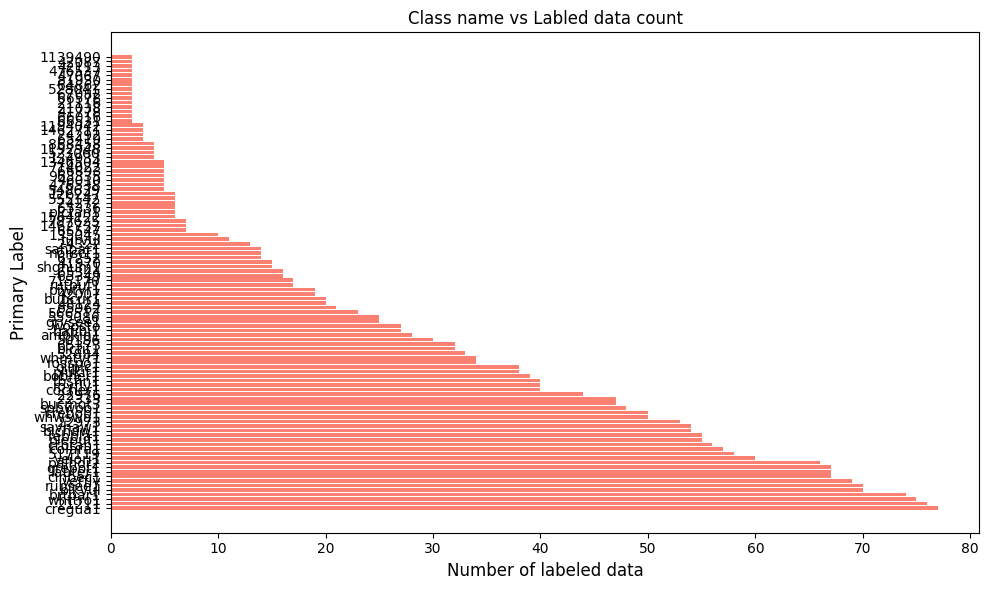

In [47]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl



top_n = 100

# 件数が少ない順に並べて、上位30件を取得
plot_df = label_counts.head(top_n)

plt.figure(figsize=(10, 6))
bars = plt.barh(plot_df['primary_label'], plot_df['num_files'], color='salmon')
plt.xlabel("Number of labeled data", fontsize=12)
plt.ylabel("Primary Label", fontsize=12)
plt.title(f"Class name vs Labled data count")
plt.gca().invert_yaxis()  # 上に少ないラベルが来るように


plt.tight_layout()
plt.show()

In [44]:
# fold0のスコアを見る．データ数とスコアの関係を見たい
model_dir_name = "models_20250404_0124"
model_dir = os.path.join(cfg.models_dir, model_dir_name)

score_df = pd.read_csv(os.path.join(model_dir, f"best_val_classwise_score_fold{0}.csv"))
score_df.rename(columns={"label": "primary_label"}, inplace=True)

merged_df = pd.merge(label_counts, score_df, on="primary_label", how="left")
merged_df

,primary_label,num_files,val_auc,val_ap
0,1139490,2,1.000000,1.000000
1,42087,2,0.744398,0.000684
2,42113,2,NaN,NaN
3,476537,2,NaN,NaN
4,47067,2,0.834559,0.001057
...,...,...,...,...
201,banana,610,0.958487,0.755751
202,roahaw,709,0.933616,0.690533
203,trokin,787,0.920412,0.710414
204,compau,808,0.985208,0.880241


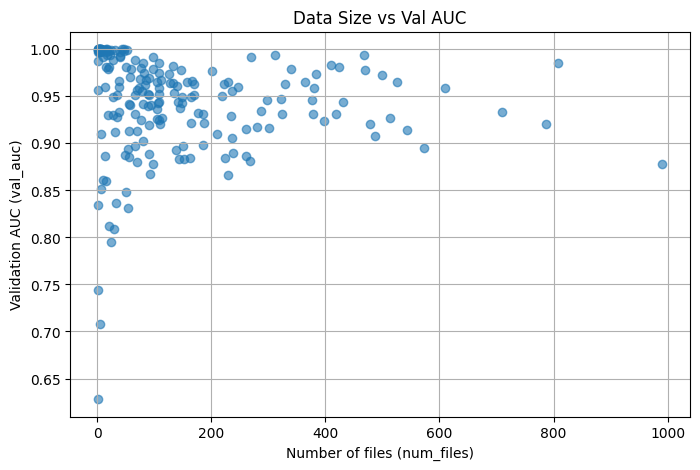

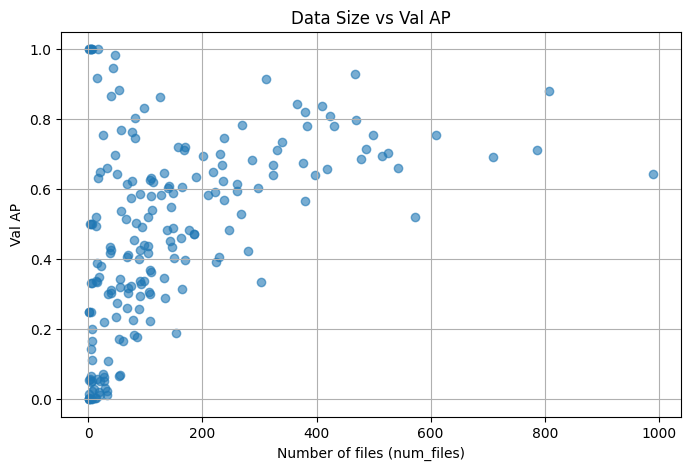

In [49]:
plt.figure(figsize=(8, 5))
plt.scatter(merged_df["num_files"], merged_df["val_auc"], alpha=0.6)
plt.xlabel("Number of files (num_files)")
plt.ylabel("Validation AUC (val_auc)")
plt.title("Data Size vs Val AUC")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(merged_df["num_files"], merged_df["val_ap"], alpha=0.6)
plt.xlabel("Number of files (num_files)")
plt.ylabel("Val AP")
plt.title("Data Size vs Val AP")
plt.grid(True)
plt.show()

In [46]:
merged_df[["num_files", "val_auc"]].corr(), merged_df[["num_files", "val_ap"]].corr()

(           num_files   val_auc
 num_files   1.000000 -0.058988
 val_auc    -0.058988  1.000000,
            num_files    val_ap
 num_files   1.000000  0.447139
 val_ap      0.447139  1.000000)

In [ ]:
# fold ごとの揺らぎを確認したい．

model_dir_name = "models_20250404_0124"
model_dir = os.path.join(cfg.models_dir, model_dir_name)

all_folds = []
for fold in range(5):
    score_df = pd.read_csv(os.path.join(model_dir, f"best_val_classwise_score_fold{fold}.csv"))
    score_df.rename(columns={"label": "primary_label"}, inplace=True)
    score_df["fold"] = fold
    all_folds.append(score_df)

all_scores = pd.concat(all_folds, ignore_index=True)

pivot_auc = all_scores.pivot(index="primary_label", columns="fold", values="val_auc")
pivot_ap = all_scores.pivot(index="primary_label", columns="fold", values="val_ap")

pivot_auc["mean_auc"] = pivot_auc.mean(axis=1)
pivot_auc["std_auc"] = pivot_auc.std(axis=1)

pivot_ap["mean_ap"] = pivot_ap.mean(axis=1)
pivot_ap["std_ap"] = pivot_ap.std(axis=1)


pivot_ap.sort_values("std_ap", ascending=False).head(10)
pivot_auc.sort_values("std_auc", ascending=False).head(10)

fold,0,1,2,3,4,mean_auc,std_auc
primary_label,,,,,,,
46010,0.708333,0.451506,0.754202,0.977241,0.984941,0.775245,0.197232
81930,0.997024,0.688375,NaN,NaN,NaN,0.842700,0.154324
135045,0.991333,0.982577,0.643845,0.961215,0.917513,0.899297,0.130252
41778,0.628151,NaN,NaN,NaN,0.382595,0.505373,0.122778
42087,0.744398,0.978116,NaN,NaN,NaN,0.861257,0.116859
turvul,0.860883,0.906305,0.677465,0.973998,0.979159,0.879562,0.110223
65373,0.999074,0.936189,0.977834,0.744057,0.991511,0.929733,0.095347
plctan1,0.999650,1.000000,0.806776,0.984153,0.990194,0.956155,0.074928
rutpuf1,0.994001,0.851463,0.822950,0.999343,0.886378,0.910827,0.072934


Text(0.5, 1.0, 'Data size vs Mean Val AUC')

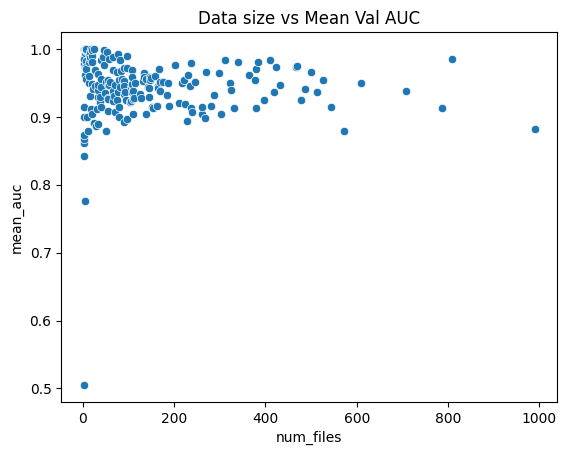

In [64]:
merged_stats = label_counts.merge(pivot_auc[["mean_auc"]], on="primary_label")
sns.scatterplot(data=merged_stats, x="num_files", y="mean_auc")
plt.title("Data size vs Mean Val AUC")

Text(0.5, 1.0, 'Data size vs Val AUC fluctuation across folds')

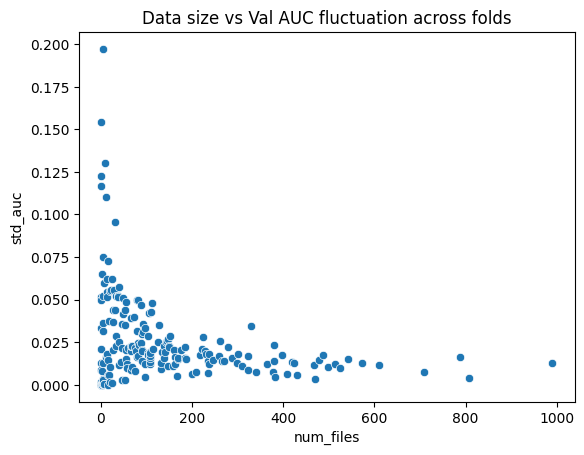

In [65]:
merged_stats = label_counts.merge(pivot_auc[["std_auc"]], on="primary_label")
sns.scatterplot(data=merged_stats, x="num_files", y="std_auc")
plt.title("Data size vs Val AUC fluctuation across folds")

Text(0.5, 1.0, 'Data size vs Mean Val AP')

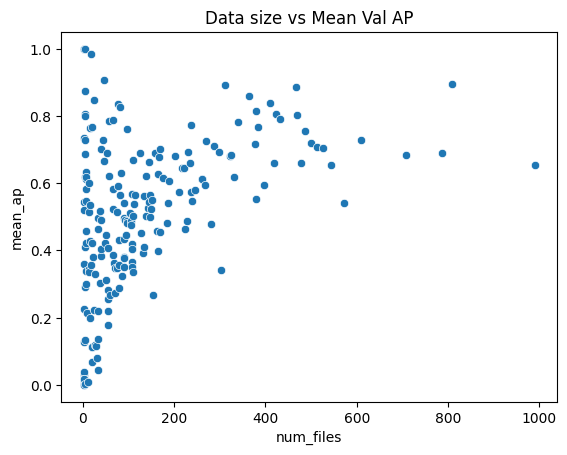

In [66]:
merged_stats = label_counts.merge(pivot_ap[["mean_ap"]], on="primary_label")
sns.scatterplot(data=merged_stats, x="num_files", y="mean_ap")
plt.title("Data size vs Mean Val AP")

Text(0.5, 1.0, 'Data size vs AP fluctuation across folds')

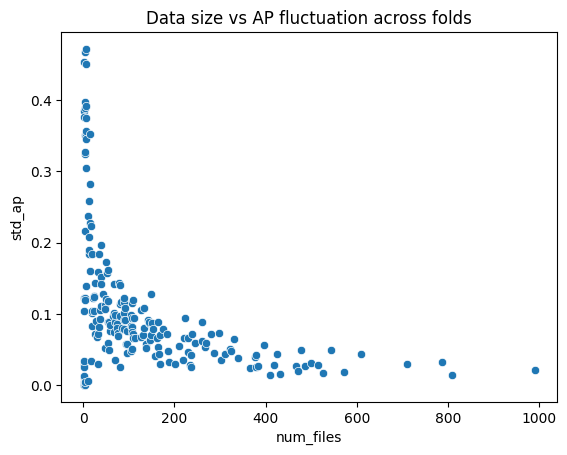

In [61]:
merged_stats = label_counts.merge(pivot_ap[["std_ap"]], on="primary_label")
sns.scatterplot(data=merged_stats, x="num_files", y="std_ap")
plt.title("Data size vs AP fluctuation across folds")

In [18]:
train_label

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0


In [19]:
label_df["primary_label"].isin(taxonomy["primary_label"].unique()).sum()

15

In [20]:
label_df["num_files"].sum(), len(all_train) - len(train_label)

(172, 157)

In [21]:
train_label

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[''],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0
28560,ywcpar,[''],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0
28561,ywcpar,[''],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0
28562,ywcpar,[''],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0


In [21]:
cfg.models_dir

'../models/'

In [22]:
import timm
print(timm.list_models('*efficientnet*'))

['efficientnet_b0', 'efficientnet_b0_g8_gn', 'efficientnet_b0_g16_evos', 'efficientnet_b0_gn', 'efficientnet_b1', 'efficientnet_b1_pruned', 'efficientnet_b2', 'efficientnet_b2_pruned', 'efficientnet_b3', 'efficientnet_b3_g8_gn', 'efficientnet_b3_gn', 'efficientnet_b3_pruned', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_b8', 'efficientnet_cc_b0_4e', 'efficientnet_cc_b0_8e', 'efficientnet_cc_b1_8e', 'efficientnet_el', 'efficientnet_el_pruned', 'efficientnet_em', 'efficientnet_es', 'efficientnet_es_pruned', 'efficientnet_l2', 'efficientnet_lite0', 'efficientnet_lite1', 'efficientnet_lite2', 'efficientnet_lite3', 'efficientnet_lite4', 'efficientnetv2_l', 'efficientnetv2_m', 'efficientnetv2_rw_m', 'efficientnetv2_rw_s', 'efficientnetv2_rw_t', 'efficientnetv2_s', 'efficientnetv2_xl', 'gc_efficientnetv2_rw_t', 'tf_efficientnet_b0', 'tf_efficientnet_b1', 'tf_efficientnet_b2', 'tf_efficientnet_b3', 'tf_efficientnet_b4', 'tf_efficientnet_b5', 'tf_eff

In [69]:
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True)

In [72]:
spectrograms.item()

{'1139490-CSA36385': array([[0.7049017 , 0.7199734 , 0.7997811 , ..., 0.734428  , 0.67589897,
         0.68217033],
        [0.7055023 , 0.71459347, 0.8169817 , ..., 0.7200174 , 0.6759654 ,
         0.66913307],
        [0.7067035 , 0.7038336 , 0.85138285, ..., 0.6911962 , 0.6760983 ,
         0.6430584 ],
        ...,
        [0.21929455, 0.24594526, 0.24758168, ..., 0.24455921, 0.23815045,
         0.25762546],
        [0.21801785, 0.24828465, 0.24967663, ..., 0.244798  , 0.24452555,
         0.25601286],
        [0.2173795 , 0.24945435, 0.2507241 , ..., 0.24491741, 0.2477131 ,
         0.25520656]], dtype=float32),
 '1139490-CSA36389': array([[0.6860932 , 0.63555586, 0.66954106, ..., 0.83289945, 0.8271354 ,
         0.7059211 ],
        [0.68805015, 0.63310075, 0.6665332 , ..., 0.8213653 , 0.82061225,
         0.71397114],
        [0.6919639 , 0.6281904 , 0.6605174 , ..., 0.7982969 , 0.80756605,
         0.73007125],
        ...,
        [0.2316096 , 0.25438875, 0.24364814, ..., 0.2